In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# DataLoader for loading and augmenting images
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets
# Early Stopping implementation
import time

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
random_seed=42

Using device: cuda


In [3]:
# Defining the trransfromation steps data aug ,resizing, normalization
train_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean/std
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# Loading the data from the train and test directories
train_dataset = datasets.ImageFolder(root='train',transform=train_transforms)
print(f"Total training images: {len(train_dataset)}")
val_dataset = datasets.ImageFolder(root='val',transform=train_transforms)
print(f"Total val images: {len(val_dataset)}")
test_dataset = datasets.ImageFolder(root='test', transform=test_transforms)
print(f"Total test images: {len(test_dataset)}")

Total training images: 4192
Total val images: 1040
Total test images: 624


In [5]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False)
print(f"Train_loader:{len(train_loader)}, val_loader:{len(val_loader)}, test_loader:{len(test_loader)}")

Train_loader:131, val_loader:33, test_loader:20


In [6]:
print(train_loader.dataset.class_to_idx)

{'normal': 0, 'opacity': 1}


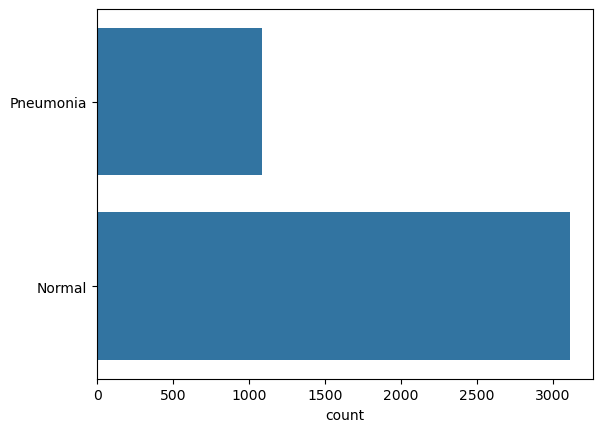

In [41]:
listx = []
for batch in train_loader:
    images, labels = batch  # 'labels' is a batch of labels, not a single label
    for label in labels:  # Iterate over individual labels in the batch
        if label.item() == 0:  # Convert tensor to scalar value using .item()
            listx.append("Pneumonia")
        else:
            listx.append("Normal")

sns.countplot(listx)
plt.savefig('class_distribution.png')  # Save as a PNG file
plt.show()
plt.close()

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedPneumoniaCNN(nn.Module):
    def __init__(self):
        super(ImprovedPneumoniaCNN, self).__init__()

        # First convolutional block with batch norm
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block with batch norm
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Add a third convolutional block for increased depth
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Increased dropout rate for more regularization
        self.dropout = nn.Dropout(0.6)  # Increased dropout to 60%

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 16 * 16, 1024)  # Adjust according to the input size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)  # Binary classification (2 outputs)

    def forward(self, x):
        # First convolutional block
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)

        # Second convolutional block
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)

        # Third convolutional block
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)

        # Flatten the feature map
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Increased dropout

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Logits for binary classification

        return x


In [35]:

# Step 2: Define your model (assuming 'model' is your defined CNN)
model = PneumoniaCNN() 
model = model.to(device)  # Move the model to GPU

# Initialize the model, loss function, and optimizer
#model = PneumoniaCNN()
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

In [39]:
import torch
from torch.utils.data import DataLoader

# Assuming model, train_loader, val_loader, criterion, and optimizer are already defined

# Define the number of epochs
num_epochs = 10

correct=0
total =0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
# Start training
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:  # Iterate over the training data
        images, labels = images.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)  # Get predictions from the model
        
        # Calculate the loss
        loss = criterion(outputs, labels)  # Compare predictions to true labels
        
        # Backward pass
        loss.backward()  # Compute gradients
        
        # Update the weights
        optimizer.step()  # Adjust the model parameters
        
        # Accumulate the loss for logging
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    
    train_accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], \n Train_Loss: {avg_loss:.4f}, Train_accuracy:{train_accuracy} ")

    # (Optional) Validate the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        val_loss = 0.0
        correct = 0
        total = 0
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_labels).item()
            _, predicted = torch.max(val_outputs.data, 1)  # Get predicted classes
            total += val_labels.size(0)  # Total number of samples
            correct += (predicted == val_labels).sum().item()  # Count correct predictions

           
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/10], 
 Train_Loss: 3.2452, Train_accuracy:86.18797709923665 
Validation Loss: 0.1775, Validation Accuracy: 93.56%
Epoch [2/10], 
 Train_Loss: 0.1239, Train_accuracy:95.01146788990826 
Validation Loss: 0.1339, Validation Accuracy: 95.10%
Epoch [3/10], 
 Train_Loss: 0.1065, Train_accuracy:95.79510703363914 
Validation Loss: 0.1505, Validation Accuracy: 94.71%
Epoch [4/10], 
 Train_Loss: 0.1016, Train_accuracy:95.85244648318043 
Validation Loss: 0.1857, Validation Accuracy: 94.33%
Epoch [5/10], 
 Train_Loss: 0.1036, Train_accuracy:95.89067278287462 
Validation Loss: 0.1513, Validation Accuracy: 94.81%
Epoch [6/10], 
 Train_Loss: 0.0923, Train_accuracy:96.19648318042813 
Validation Loss: 0.1679, Validation Accuracy: 95.77%
Epoch [7/10], 
 Train_Loss: 0.0878, Train_accuracy:96.42584097859327 
Validation Loss: 0.1870, Validation Accuracy: 94.52%
Epoch [8/10], 
 Train_Loss: 0.0878, Train_accuracy:96.19648318042813 
Validation Loss: 0.1833, Validation Accuracy: 94.04%
Epoch [9/10], 
 

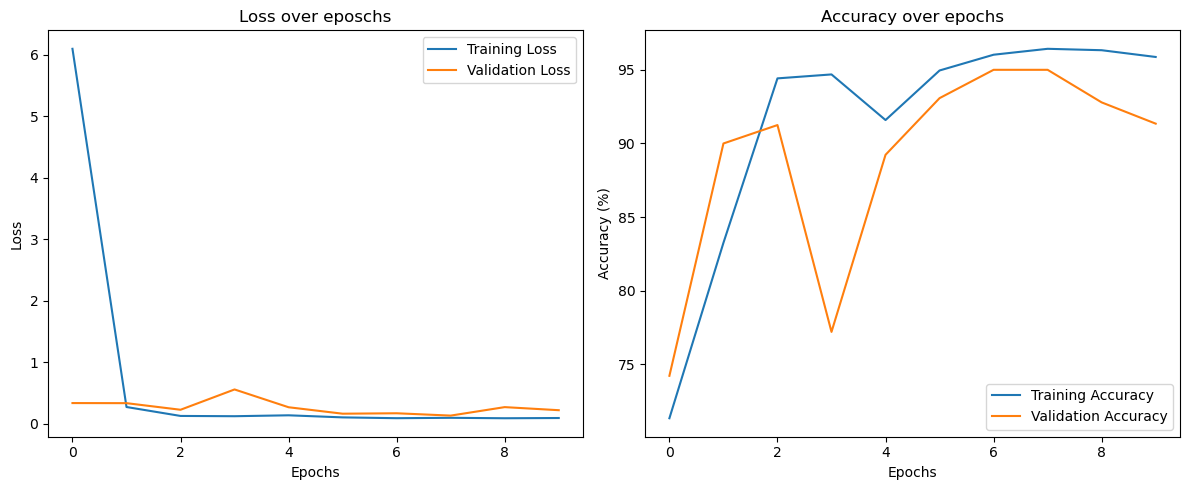

In [12]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over eposchs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()

plt.savefig('training_validation_loss_accuracy.png')  # Save as a PNG file
plt.show()

plt.close()

True Positives: 363
False Positives: 60
True Negatives: 174
False Negatives: 27


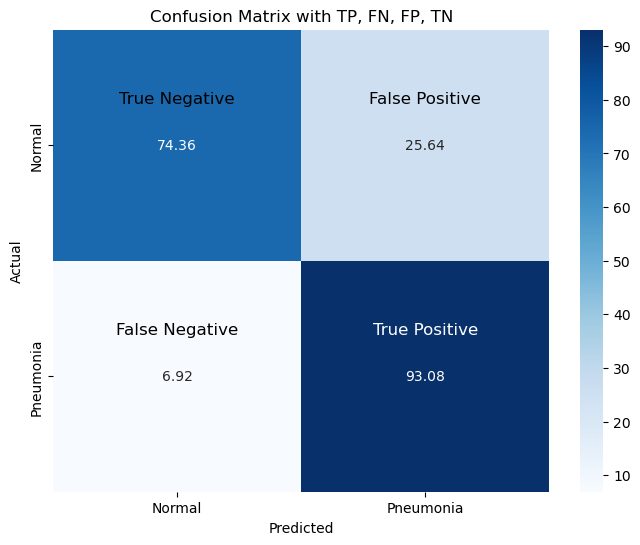

In [13]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have your model evaluation loop to get predictions
predicted = []
all_labels = []

# Model evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:  # Replace with your data loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predicted.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, predicted)
tn, fp, fn, tp = cm.ravel()  # Extract values


# Print TP, FP, TN, FN
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")

# Normalize the confusion matrix to get percentages
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])

# Add TP and FN text to the heatmap
plt.text(0.5, 0.3, f'True Negative', ha='center', va='center', color='black', fontsize=12)
plt.text(0.5, 1.3, f'False Negative', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 0.3, f'False Positive', ha='center', va='center', color='black', fontsize=12)
plt.text(1.5, 1.3, f'True Positive', ha='center', va='center', color='white', fontsize=12)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix with TP, FN, FP, TN')
plt.savefig('confusion_matrix_with_metrics.png')  # Save confusion matrix as an image
plt.show()


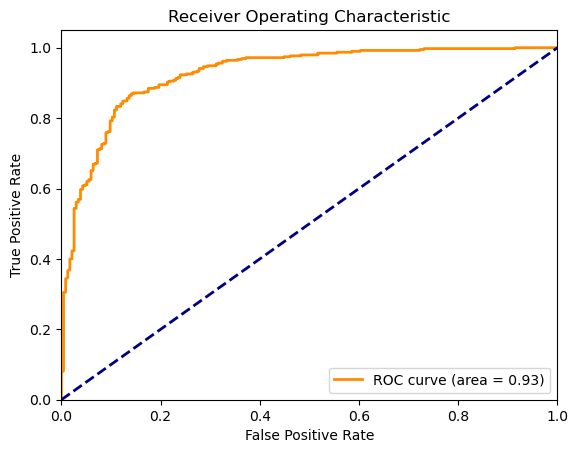

AUC: 92.63%
Test Accuracy: 72.92%


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score

# Collect predictions and true labels
all_labels = []
all_probs = []
all_predictions = []  # List to hold all predictions

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = model(test_images)
        
        # Get probabilities for the positive class (assuming class 1 is pneumonia)
        test_probs = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()

        all_labels.extend(test_labels.cpu().numpy())  # Collect labels
        all_probs.extend(test_probs)  # Collect probabilities
        
        # Get predicted classes
        predictions = torch.argmax(test_outputs, dim=1).cpu().numpy()
        all_predictions.extend(predictions)  # Collect predictions

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)
all_predictions = np.array(all_predictions)

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)  # Calculate accuracy

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("roc_curve_train_test.png")  # Save the ROC curve as a PNG file
plt.show()  # Display the plot

# Display AUC and Test Accuracy
print(f"AUC: {roc_auc * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [ ]:
# Assuming 'model' is your trained model

# Save the model in HDF5 format
model.save('pneumonia_model.h5')
print("Model saved to pneumonia_model.h5")
